In [2]:
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from matplotlib import pyplot as plt
%matplotlib inline
import re
import os,sys, shutil
import time
from datetime import date
try:
    import cPickle as pickle
except:
    import pickle
import pprint
from collections import deque
from shutil import copyfile
import random
import glob
# Import the required modules
import cv2, os
import numpy as np
from PIL import Image
from sklearn.cross_validation import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
import pandas as pd
import math
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [3]:
pkl_fl = open("linkedin_profiles.pickle","rb")
my_original_list=pickle.load(pkl_fl) # errors out here
pkl_fl.close()

In [ ]:
directory = "Male"
    
if os.path.exists(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)     
else:
    os.makedirs(directory) 

directory1 = "Female"

if os.path.exists(directory1):
    shutil.rmtree(directory1)
    os.makedirs(directory1)     
else:
    os.makedirs(directory1)     

directory2 = "Label_Images_Age"

if os.path.exists(directory2):
    shutil.rmtree(directory2)
    os.makedirs(directory2)     
else:
    os.makedirs(directory2)     
    
fileList = glob.glob("./Images/*.*")

for id,fp in enumerate(fileList):
    filename, file_extension = os.path.splitext(fp)
    uid = filename.split('/')[-1]
    #print fp
    for prof in my_original_list:
        if prof['User_ID'] == uid:
            prof_age = prof['age']
            
            if (0 <= prof_age <= 30):
                new_file_extension = 'Youth'
            else:
                new_file_extension = 'Senior'
            
            copyfile(filename + ".jpg", './Label_Images_Age/'+ uid + '.' + str(id) + "." + new_file_extension +'.jpg')

In [4]:
# For face detection we will use the Haar Cascade provided by OpenCV.
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

# For face recognition we will the the LBPH Face Recognizer 
recognizer = cv2.createLBPHFaceRecognizer()

In [26]:
def get_images_and_labels(path):
    # Append all the absolute image paths in a list image_paths
    
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    # images will contains face images
    images = []
    # labels will contains the label that is assigned to the image
    labels = []
    #gender will contains 1 or 0 indecating male or female
    age =[]
    
    for image_path in image_paths:
        # Read the image and convert to grayscale
        try:
            image_pil = Image.open(image_path).convert('L')
            # Convert the image format into numpy array
            image = np.array(image_pil, 'uint8')
            # Get the label of the image
        except:
            pass
        
        nbr = int(os.path.split(image_path)[1].split(".")[1])
        age_current = os.path.split(image_path)[1].split(".")[2]
        #print nbr
        
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        try:
            for (x, y, w, h) in faces:

                ref_image = image[y: y + h, x: x + w]
                resized = cv2.resize(ref_image, (100, 100), interpolation = cv2.INTER_AREA)
                #edge_images = cv2.Canny(resized,100,200)
                resized_face = cv2.resize(ref_image, (100, 100), interpolation = cv2.INTER_AREA)
                
                images.append(np.array(resized))   #resized.reshape(1,10000)
                labels.append(nbr)

                if age_current == 'Youth':
                    age.append(0)
                
                else:
                    age.append(1)
                
                #face_file_name = "faces/face_" + str(y) + ".jpg"
                #cv2.imwrite(face_file_name, sub_face)
                
                cv2.imshow("Adding faces to traning set...", resized)
                cv2.waitKey(1)
        except:
            pass
    # return the images list and labels list
    #print "lables"
    #print labels
    #print "Age_current"
    #print age
    
    return images, labels, age

In [27]:
images, labels, ageList = get_images_and_labels('Label_Images_Age')

cv2.destroyAllWindows()

In [28]:
#res_images = []
res_age = []

for age in ageList:
    res_age.append(np.array(age))
                   
res_age = np.array(res_age)

In [29]:
res_age.shape

(2968,)

## Basic model parameters as external flags.

In [12]:
# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('hidden1', 1500, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 1000, 'Number of units in hidden layer 2.')
flags.DEFINE_integer('hidden3', 500, 'Number of units in hidden layer 3.')
flags.DEFINE_integer('batch_size', 100, 'Batch size.  '
                     'Must divide evenly into the dataset sizes.')
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')
flags.DEFINE_boolean('fake_data', False, 'If true, uses fake data '
                     'for unit testing.')


NUM_CLASSES = 2
IMAGE_SIZE = 100
#CHANNELS = 3
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

In [30]:
n_nodes = [IMAGE_PIXELS, 1500, 1000, 500, NUM_CLASSES]
n_epochs = 10
#NUM_CLASSES = 3

In [31]:
def neural_network_model(data):
    n_hidden_layers = 3
    # define the layers
    layers = [] 
    for i in range(n_hidden_layers + 1):
        layers.append( {'weights':tf.Variable(tf.random_normal([n_nodes[i], n_nodes[i+1]])), 
                        'biases':tf.Variable(tf.random_normal([n_nodes[i+1]]))} )
    
    # calculate the nodal values for each layer
    calcs = [data]
    for i in range(n_hidden_layers):
        calcs.append( tf.nn.relu(tf.matmul(calcs[i], layers[i]['weights']) + layers[i]['biases']) )

    #  return the last layer of nodes
    return tf.matmul(calcs[-1], layers[-1]['weights']) + layers[-1]['biases']

In [32]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
  
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [33]:
def placeholder_inputs():
    images_placeholder = tf.placeholder(tf.float32, [None,IMAGE_PIXELS])
    labels_placeholder = tf.placeholder(tf.float32, [None,NUM_CLASSES])
    
    return images_placeholder, labels_placeholder


def fill_feed_dict(images_feed,labels_feed, images_pl, labels_pl):
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
  
    return feed_dict

In [34]:
# def do_eval(sess, eval_correct, images_placeholder, labels_placeholder, data_set):
#     # And run one epoch of eval.
#     true_count = 0  # Counts the number of correct predictions.
#     steps_per_epoch = 47 // FLAGS.batch_size
#     num_examples = steps_per_epoch * FLAGS.batch_size
#     for step in xrange(steps_per_epoch):
#         feed_dict = fill_feed_dict(train_images,train_labels,
#                                images_placeholder,
#                                labels_placeholder)
#         true_count += sess.run(eval_correct, feed_dict=feed_dict)
#     precision = true_count / num_examples
#     print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
#         (num_examples, true_count, precision))

In [35]:
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [36]:
def main():
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Generate placeholders for the images and labels.
        images_placeholder, labels_placeholder = placeholder_inputs()
        
        
        logits = neural_network_model(images_placeholder)
        
        
        cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits,labels_placeholder) )
        training_acc = []
        testing_acc = []
       
        #print cost
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
        
            subset_size = 128
            for step in xrange(200):
                start_time = time.time()
                total_loss = 0
                for i in range(int(train_images.shape[0] / subset_size) ):
                    
                    epoch_x = train_images[i * subset_size:][:subset_size]
                    epoch_y = train_labels[i * subset_size:][:subset_size]
                    
                    feed_dict = fill_feed_dict(epoch_x, epoch_y, images_placeholder, labels_placeholder)
                    
                    _, loss_value = sess.run([optimizer, cost],
                                           feed_dict=feed_dict)
                    
                    total_loss+=loss_value
                    
                duration = time.time() - start_time
                #if step % 10 == 0:
                    #Print status to stdout.
                correct = tf.equal(tf.argmax(logits,1), tf.argmax(labels_placeholder,1))
                #print correct
                accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
                
                print('Step %d: loss = %.2f (%.3f sec)' % (step, total_loss, duration)),
                
                current_train_acc = accuracy.eval({images_placeholder: train_images, labels_placeholder: train_labels})
                current_test_acc = accuracy.eval({images_placeholder: test_images, labels_placeholder: test_labels})
                
                training_acc.append(current_train_acc)
                testing_acc.append(current_test_acc)
                
                
                print('Training Accuracy:', current_train_acc),
                print('Testing Accuracy:', current_test_acc)
    
    return training_acc, testing_acc

In [37]:
# Get the sets of images and labels for training, validation, and

images = np.array(images)
images = images.reshape(images.shape[0],IMAGE_PIXELS)

#label = res_gender
labels = dense_to_one_hot(res_age,2)

In [38]:
train_images = images[:-300]
train_labels = labels[:-300]
test_images = images[-300:]
test_labels = labels[-300:]

In [39]:
train_images.shape

(2668, 10000)

In [40]:
train_labels[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [48]:
if __name__ == '__main__':
    train_acc, test_acc = main()

Step 0: loss = 395528670.00 (20.735 sec) ('Training Accuracy:', 0.58523792) ('Testing Accuracy:', 0.55666667)
Step 1: loss = 220396099.00 (18.116 sec) ('Training Accuracy:', 0.54589736) ('Testing Accuracy:', 0.54000002)
Step 2: loss = 179621873.00 (18.783 sec) ('Training Accuracy:', 0.57474709) ('Testing Accuracy:', 0.57333332)
Step 3: loss = 155101924.50 (18.809 sec) ('Training Accuracy:', 0.58673662) ('Testing Accuracy:', 0.56666666)
Step 4: loss = 134338255.50 (18.091 sec) ('Training Accuracy:', 0.6140877) ('Testing Accuracy:', 0.55666667)
Step 5: loss = 119382057.00 (18.524 sec) ('Training Accuracy:', 0.62233049) ('Testing Accuracy:', 0.56666666)
Step 6: loss = 109150841.00 (18.371 sec) ('Training Accuracy:', 0.6140877) ('Testing Accuracy:', 0.52999997)
Step 7: loss = 100355448.50 (18.288 sec) ('Training Accuracy:', 0.64368677) ('Testing Accuracy:', 0.55000001)
Step 8: loss = 90316874.00 (18.259 sec) ('Training Accuracy:', 0.65979767) ('Testing Accuracy:', 0.56333333)
Step 9: loss 

In [41]:
if __name__ == '__main__':
    train_acc_whole, test_acc_whole = main()

Step 0: loss = 426029532.00 (9.126 sec) ('Training Accuracy:', 0.58883059) ('Testing Accuracy:', 0.57999998)
Step 1: loss = 224952667.00 (10.641 sec) ('Training Accuracy:', 0.54610193) ('Testing Accuracy:', 0.47666666)
Step 2: loss = 186282770.50 (8.754 sec) ('Training Accuracy:', 0.57608694) ('Testing Accuracy:', 0.52666664)
Step 3: loss = 157188716.00 (8.744 sec) ('Training Accuracy:', 0.6064468) ('Testing Accuracy:', 0.55000001)
Step 4: loss = 141595672.00 (9.254 sec) ('Training Accuracy:', 0.60607195) ('Testing Accuracy:', 0.53666669)
Step 5: loss = 126091908.00 (9.422 sec) ('Training Accuracy:', 0.61731637) ('Testing Accuracy:', 0.56333333)
Step 6: loss = 114848935.00 (9.681 sec) ('Training Accuracy:', 0.62668663) ('Testing Accuracy:', 0.56333333)
Step 7: loss = 108071643.00 (10.035 sec) ('Training Accuracy:', 0.61731637) ('Testing Accuracy:', 0.52666664)
Step 8: loss = 101031114.25 (10.724 sec) ('Training Accuracy:', 0.6555472) ('Testing Accuracy:', 0.55000001)
Step 9: loss = 896

In [24]:
if __name__ == '__main__':
    train_acc_face, test_acc_face = main()

Step 0: loss = 378075023.00 (9.125 sec) ('Training Accuracy:', 0.57999253) ('Testing Accuracy:', 0.58333331)
Step 1: loss = 212032418.00 (9.085 sec) ('Training Accuracy:', 0.5533908) ('Testing Accuracy:', 0.52333331)
Step 2: loss = 176671522.00 (8.689 sec) ('Training Accuracy:', 0.54627204) ('Testing Accuracy:', 0.50666666)
Step 3: loss = 162068939.00 (8.989 sec) ('Training Accuracy:', 0.53016108) ('Testing Accuracy:', 0.48666668)
Step 4: loss = 159282855.00 (12.244 sec) ('Training Accuracy:', 0.54140127) ('Testing Accuracy:', 0.49000001)
Step 5: loss = 168716221.00 (9.482 sec) ('Training Accuracy:', 0.64968151) ('Testing Accuracy:', 0.5933333)
Step 6: loss = 142647160.00 (9.258 sec) ('Training Accuracy:', 0.67103785) ('Testing Accuracy:', 0.63999999)
Step 7: loss = 112778716.75 (9.235 sec) ('Training Accuracy:', 0.66654176) ('Testing Accuracy:', 0.57666665)
Step 8: loss = 99121671.00 (9.277 sec) ('Training Accuracy:', 0.65792429) ('Testing Accuracy:', 0.57666665)
Step 9: loss = 885079

In [53]:
max(train_acc)

0.98051703

In [52]:
max(test_acc)

0.67000002

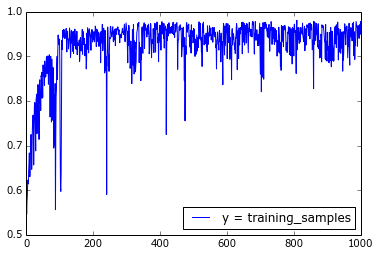

In [50]:
x = np.arange(1000)

plt.plot(x, train_acc)
#plt.plot(x, test_acc)


plt.legend(['y = training_samples', 'y = testing_samples'], loc='lower right')

plt.show()

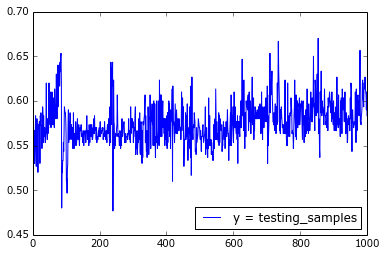

In [51]:
x = np.arange(1000)

plt.plot(x, test_acc)


plt.legend(['y = testing_samples'], loc='lower right')

plt.show()

In [55]:
accuracy_list = pd.DataFrame(
    {'Training_Acc': train_acc,
     'Testing_Acc': test_acc,
    })

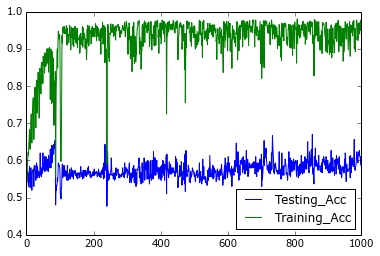

In [59]:
accuracy_list.plot()

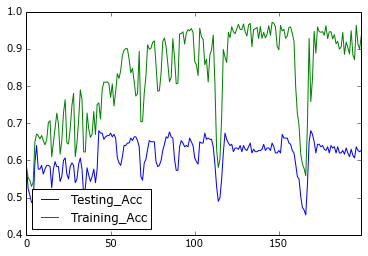

In [25]:
accuracy_list_face = pd.DataFrame(
    {'Training_Acc': train_acc_face,
     'Testing_Acc': test_acc_face,
    })
accuracy_list_face.plot()

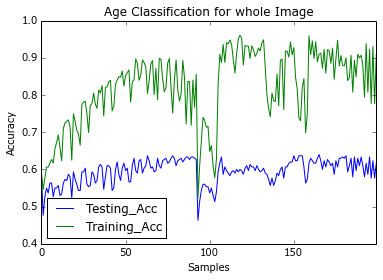

In [44]:
accuracy_list_whole = pd.DataFrame(
    {'Training_Acc': train_acc_whole,
     'Testing_Acc': test_acc_whole,
    })

ax = accuracy_list_whole.plot(title='Age Classification for whole Image')
ax.set_xlabel("Samples")
ax.set_ylabel("Accuracy")